In [1]:
import pandas as pd

In [122]:
df = pd.read_csv("/content/airline_sentiment_analysis.csv")

In [113]:
df

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...,...
11536,14633,negative,@AmericanAir my flight was Cancelled Flightled...
11537,14634,negative,@AmericanAir right on cue with the delays👌
11538,14635,positive,@AmericanAir thank you we got on a different f...
11539,14636,negative,@AmericanAir leaving over 20 minutes Late Flig...


In [4]:
for index, row in df.iterrows():
  if index == 50:
    break
  print(row["airline_sentiment"], "   ", row["text"])


positive     @VirginAmerica plus you've added commercials to the experience... tacky.
negative     @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
negative     @VirginAmerica and it's a really big bad thing about it
negative     @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
positive     @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
positive     @virginamerica Well, I didn't…but NOW I DO! :-D
positive     @VirginAmerica it was amazing, and arrived an hour early. You're too good to me.
positive     @VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D
positive     @VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p
positive     @VirginAmerica @virginmedia I'm flying your #

In [5]:
# virginamerica can be removed from the sentence 
# remove stop words
# lowercase
# remove punctuation 
# remove emoji (https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b)
# lemmatization 




In [123]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk

In [124]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [125]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [126]:
X,y = df['text'].values,df['airline_sentiment'].values
#stratify will preserve the distribution of the classes in the test and train data equally
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of train labels is {y_train.shape}')
print(f'shape of test data is {x_test.shape}')
print(f'shape of test labels is {y_test.shape}')

shape of train data is (8655,)
shape of train labels is (8655,)
shape of test data is (2886,)
shape of test labels is (2886,)


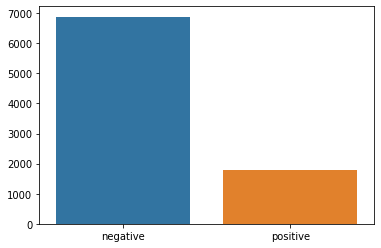

In [127]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

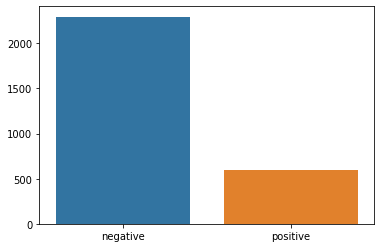

In [128]:
dd = pd.Series(y_test).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [21]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s


In [13]:
preprocess_string("@VirginAmerica @ladygaga @carrieunderwood  I'm Lady Gaga!!! She is amazing! 😊")

'VirginAmericaladygagacarrieunderwoodImLadyGagaSheisamazing'

In [129]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)

    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:10000]
    # print(len(corpus_))

    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    print(len(onehot_dict))
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [130]:
X_train,Y_train,X_test,Y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

10000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [121]:
len(vocab) + 1

10001

In [23]:
len(X_train[0])

15

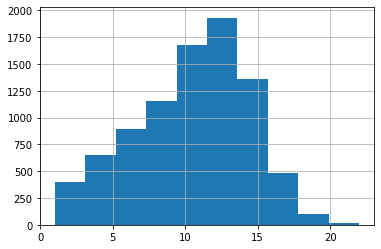

count    8655.000000
mean       10.519469
std         3.747744
min         1.000000
25%         8.000000
50%        11.000000
75%        13.000000
max        22.000000
dtype: float64

In [131]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [132]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [133]:
#keeping the uniform sequence length as 25, since the sentences in our dataset have a general length of 21
x_train_pad = padding_(X_train,25)
x_test_pad = padding_(X_test,25)

In [134]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(Y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(Y_test))

batch_size = 50

#Preparing the dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [135]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 25])
Sample input: 
 tensor([[   0,    0,    0,  ..., 1091,  958,    2],
        [   0,    0,    0,  ..., 8250,   28,  306],
        [   0,    0,    0,  ...,  271,    2,  247],
        ...,
        [   0,    0,    0,  ..., 2825, 1471,  646],
        [   0,    0,    0,  ...,  360,  473,   12],
        [   0,    0,    0,  ...,   47,   55,  184]])
Sample input: 
 tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0])


In [136]:
len(vocab) + 1

10001

In [ ]:
#hyperparams 
# (1) Length of the input sequence 
# (2) No of hidden layers
# (3) vocab size all or few ? 
# (4) no of layers 
# (5) Hidden dimension


In [146]:

class Model_predict(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(Model_predict,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        # print(embeds.shape)  
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [147]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = Model_predict(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

model.to(device)

print(model)

Model_predict(
  (embedding): Embedding(10001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [139]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [142]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        if inputs.shape == (5,25):
          continue
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # creating new variables h so that backprop is only done till here and not linked to the past
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            if inputs.shape == (36,25):
              continue

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), "/content/sa.pth")
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.06609157686030244 val_loss : 0.39255798581922263
train_accuracy : 97.65453495089544 val_accuracy : 87.6992376992377
Validation loss decreased (inf --> 0.392558).  Saving model ...
Epoch 2
train_loss : 0.04127993917286482 val_loss : 0.47631739720440747
train_accuracy : 98.54419410745234 val_accuracy : 87.8031878031878
Epoch 3
train_loss : 0.02631750192077335 val_loss : 0.6368877294293621
train_accuracy : 99.052570768342 val_accuracy : 87.31808731808732
Epoch 4
train_loss : 0.010704036522623033 val_loss : 0.5597484771881187
train_accuracy : 99.60716348931254 val_accuracy : 87.62993762993763
Epoch 5
train_loss : 0.018875620778578715 val_loss : 0.5472151812231332
train_accuracy : 99.31831311380705 val_accuracy : 87.04088704088704


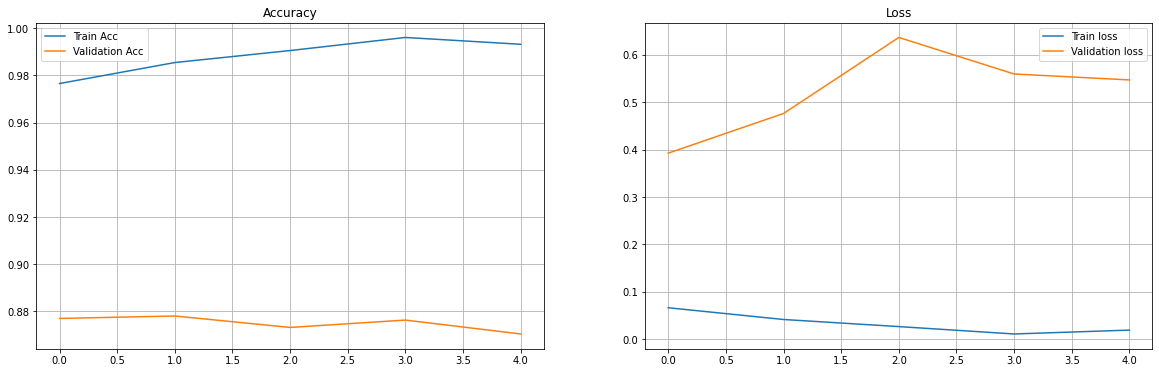

In [143]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

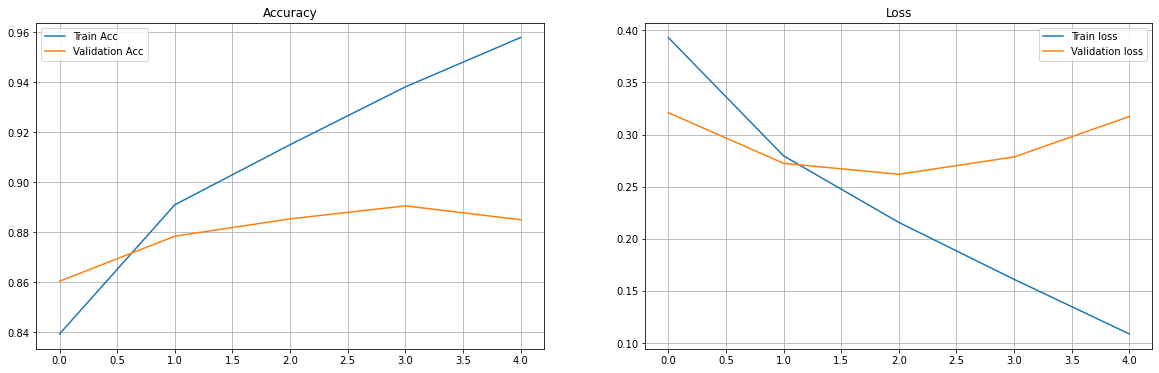

In [65]:
# increasing the dropout to reduce any chances of overfitting 
# now dropout = 0.4

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


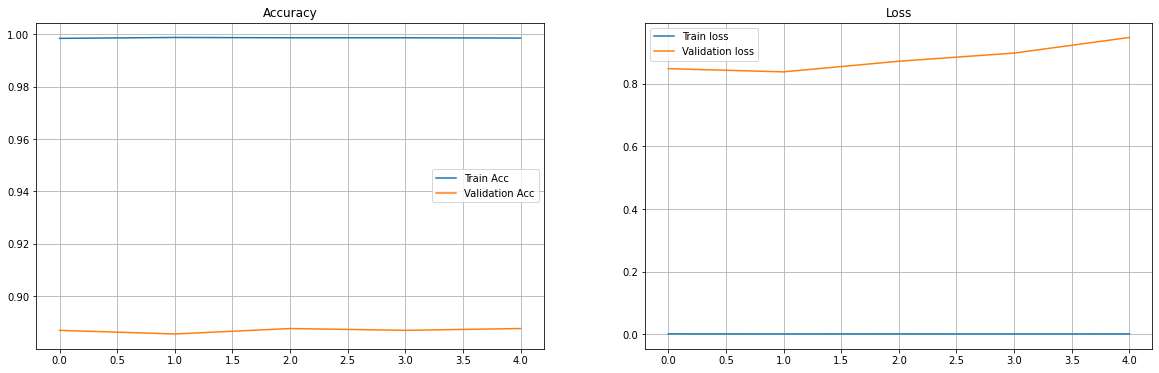

In [77]:
#the problem is not with the capacity of the model, rather the model is performing very well on the train data... not exactly overfitting, hence we can probably reduce the dimensions to reduce the chances of overfitting if any

#effect fo reducing the capacity of the model.... changed the no of layers to 1
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()



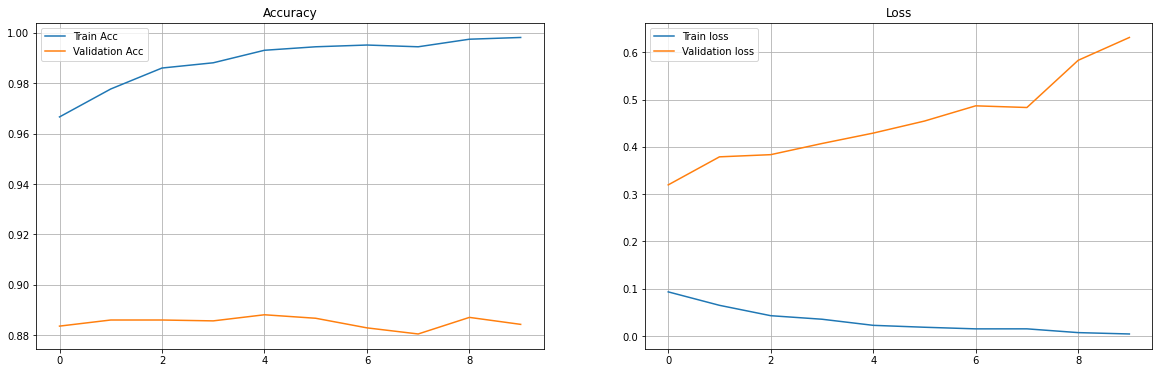

In [83]:
#reducing the hidden layer dimension to half (does not help)

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


In [144]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,25))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [145]:
index = 41
print(df['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["airline_sentiment"][index]}')
print('='*70)
pro = predict_text(df['text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

@VirginAmerica Hi, Virgin! I'm on hold for 40-50 minutes -- are there any earlier flights from LA to NYC tonight; earlier than 11:50pm?
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.9999367531345342
